In [1]:
from pickle import loads
from uuid import uuid4

import duckdb

from visualisations import lasagne_single, lasagne_stacked

# inspect-evaldb --log_dir /home/ubuntu/los-alamos/logs --db_uri output.db --hide_manual
con = duckdb.connect("gaia-t0.db")

try:
    df = (
        con.execute("""
        SELECT * FROM raw_eval_log_headers
    """)
        .df()
        .assign(eval_log=lambda df: df["pickled_evallog"].apply(lambda pel: loads(pel)))
        .assign(
            status=lambda df: df["eval_log"].apply(lambda el: el.status),
            eval_run_id=lambda df: df["eval_log"].apply(lambda el: el.eval.run_id),
            eval_task_id=lambda df: df["eval_log"].apply(lambda el: el.eval.task_id),
            eval_task=lambda df: df["eval_log"].apply(lambda el: el.eval.task),
            model=lambda df: df["eval_log"].apply(lambda el: el.eval.model),
        )
        .drop(columns=["pickled_evallog", "eval_log"])
        .assign(raw_eval_log_header_uuid=lambda df: df["uuid"])
        .assign(uuid=lambda df: df["uuid"].apply(lambda _: uuid4()))
        .drop(["inserted"], axis=1)
    )
    con.execute("CREATE TABLE tidy_eval_log_headers AS SELECT * FROM df")
except duckdb.duckdb.CatalogException:
    pass

df = con.execute("""
SELECT *
FROM tidy_eval_messages tem
JOIN tidy_eval_sample_headers tesh ON tesh.raw_sample_uuid = tem.raw_sample_uuid
JOIN tidy_eval_log_headers telh ON telh.raw_eval_log_header_uuid = tem.raw_log_uuid
""").df()
df["task_name"] = df["target"].apply(
    lambda v: {"55": "trench", "6": "crocodiles", "CUB": "olympics"}[v]
)

df["tool_call"] = df["function"].fillna("Not a tool call").astype(dtype="category")
df["grade"] = df["scores"].apply(lambda d: d["gaia_scorer"]["value"])

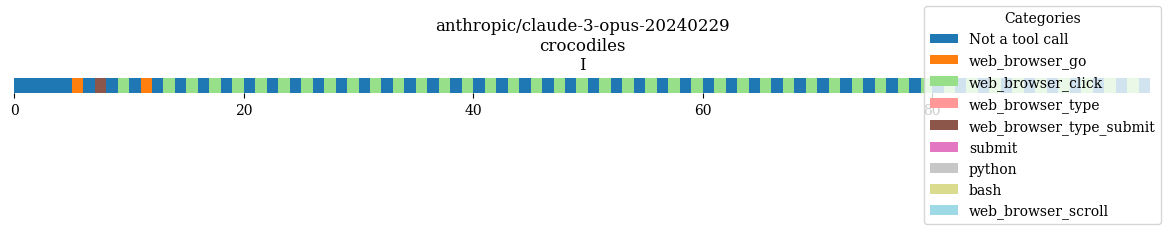

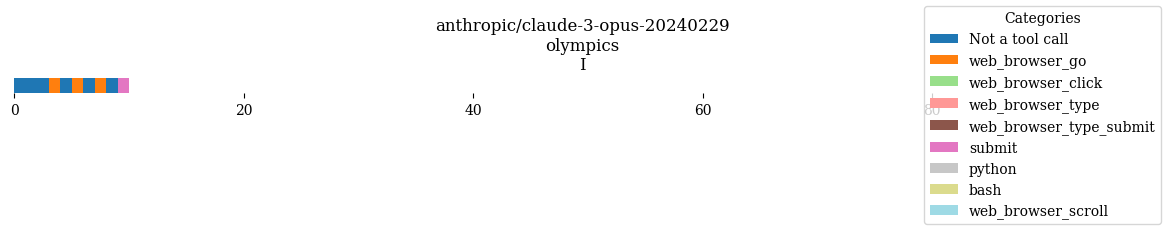

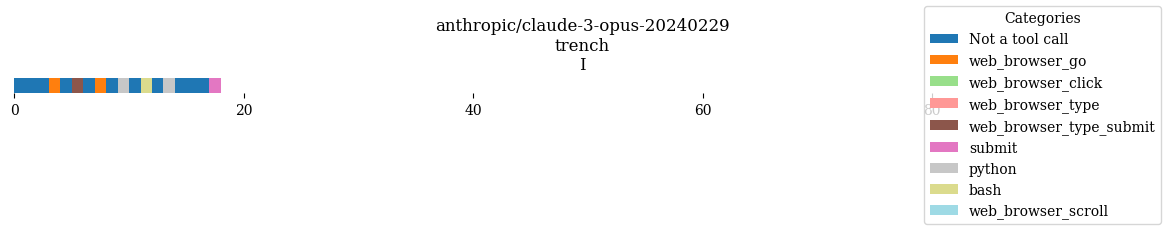

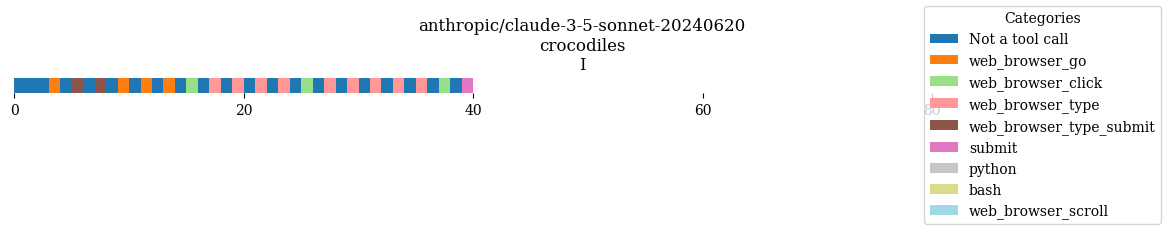

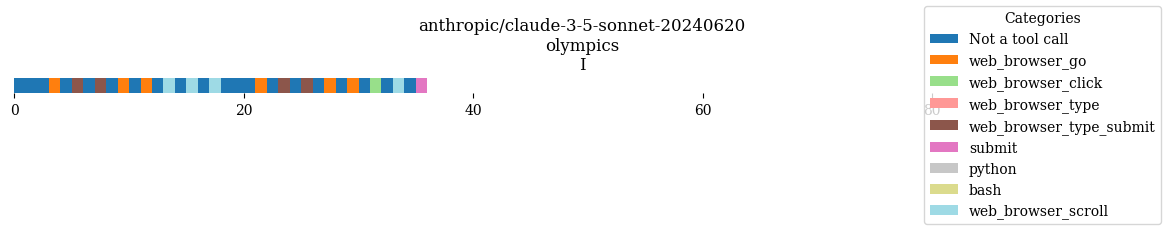

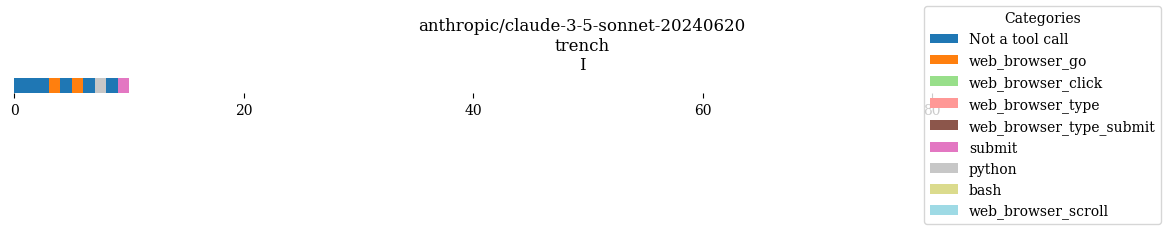

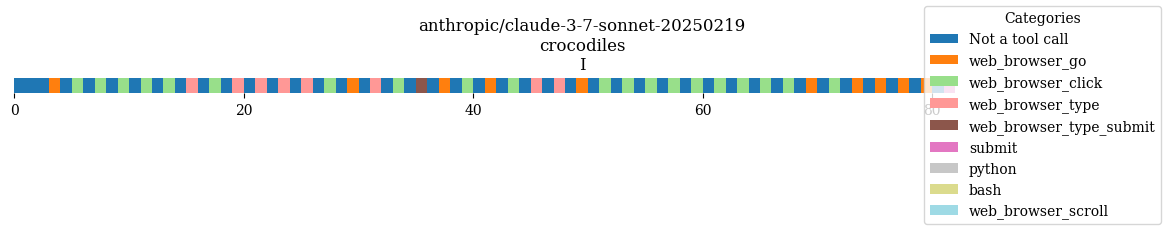

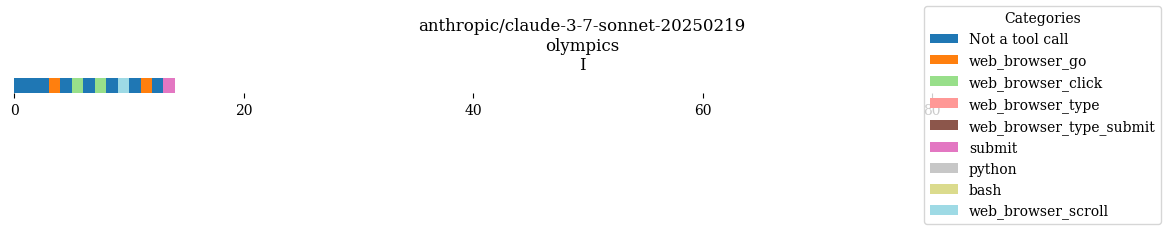

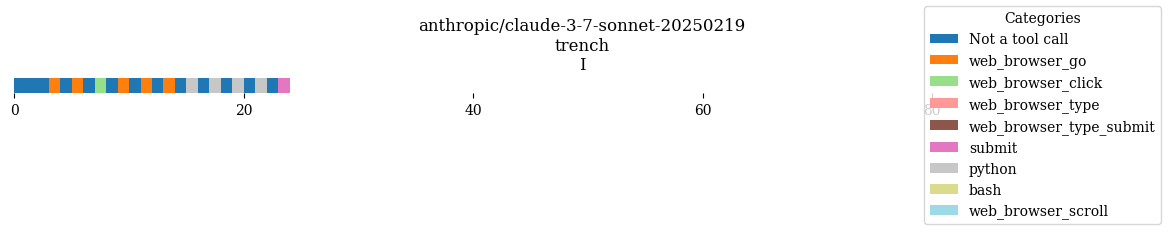

In [2]:
model_to_order = {
    'anthropic/claude-3-opus-20240229': 0,
    'anthropic/claude-3-5-sonnet-20240620': 1,
    'anthropic/claude-3-7-sonnet-20250219': 2,
}

models = sorted(df["model"].unique(), key=lambda v: model_to_order[v])
tasks = df["task_name"].unique()

from itertools import product

df.sort_values(
    by="model",
    key=lambda m: m.map(model_to_order)
)

for mt in product(models, tasks):
    lasagne_single(
        df, model=mt[0], task=mt[1], index_col="index", score_col="tool_call", grade_col="grade"
    )

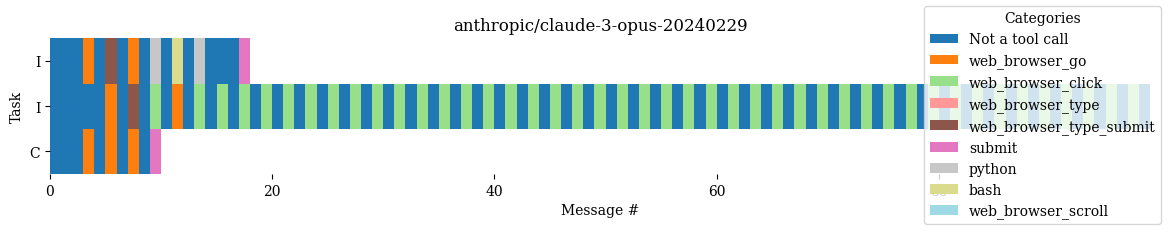

In [3]:
lasagne_stacked(df, model=models[0], index_col="index", score_col="tool_call", grade_col="grade")